### 1. The LASSO and Boosting for Regression

(a)

In [1]:
import numpy as np
import pandas as pd
from scipy.io import arff 

# removed non-predictive features: 'state', 'country', 'community', 'communityname', 'fold'
# converted the original .data & .names file into .arff file

f = open('../data/communities.arff', 'r')
data = arff.loadarff(f)
df = pd.DataFrame(data[0])

# splitting training/test data set
df_tr = df[:1495]
df_te = df[-499:]

In [2]:
print('The shape of training set is:', df_tr.shape)
print('Total number of NaN in training set: ', df_tr.isna().sum().sum())

The shape of training set is: (1495, 123)
Total number of NaN in training set:  27633


In [3]:
print('The shape of test set is:', df_te.shape)
print('Total number of NaN in test set: ', df_te.isna().sum().sum())

The shape of test set is: (499, 123)
Total number of NaN in test set:  9218


(b)

In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# train multivariate imputer in training data set
imp = IterativeImputer(max_iter = 10, random_state = 0)
imp.fit(df_tr)

# inpute new training & test data set with trained imputer
df_train = pd.DataFrame(data = imp.transform(df_tr), index = df_tr.index, columns = df_tr.columns)
df_test = pd.DataFrame(data = imp.transform(df_te), index = df_te.index, columns = df_te.columns)

D:\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [5]:
print('Total number of NaN in imputed training set: ', df_train.isna().sum().sum())
print('Total number of NaN in imputed test set: ', df_test.isna().sum().sum())

Total number of NaN in imputed training set:  0
Total number of NaN in imputed test set:  0


(c)

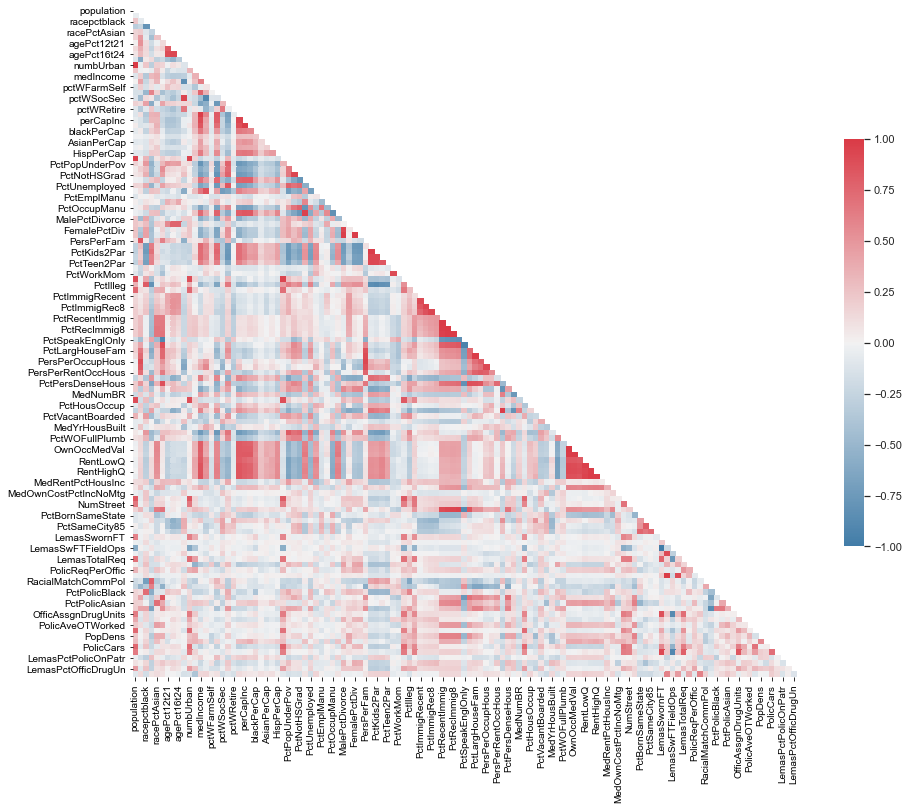

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# get features
X_train = df_train.drop(['ViolentCrimesPerPop'], axis = 1)
X_test = df_test.drop(['ViolentCrimesPerPop'], axis = 1)

# compute correlation matrix of features
corr = X_train.corr()

# plot heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(240, 10, as_cmap = True)
sns.set(font_scale = 1)
sns.heatmap(corr, mask = mask, cmap = cmap, vmin = -1, vmax = 1, center = 0, square = True,
            xticklabels = 'auto', yticklabels = 'auto', linewidths = 0, cbar_kws={'shrink': 0.5}).set_facecolor('white')

(d)

In [7]:
cv = df_train.apply(lambda x: np.std(x)/np.mean(x), axis = 0)
cv

population             2.240355
householdsize          0.355681
racepctblack           1.428407
racePctWhite           0.330102
racePctAsian           1.358645
                         ...   
LemasPctPolicOnPatr    0.132875
LemasGangUnitDeploy    0.439235
LemasPctOfficDrugUn    2.552092
PolicBudgPerPop        0.402334
ViolentCrimesPerPop    0.987578
Length: 123, dtype: float64

(e)

In [8]:
import math
high_cv = cv.nlargest(n = math.floor(math.sqrt(123))).index
high_cv # pick ⌊√123⌋ features with highest CV

Index(['OfficAssgnDrugUnits', 'NumStreet', 'LemasTotalReq', 'NumInShelters',
       'NumIlleg', 'NumImmig', 'LemasPctOfficDrugUn', 'PctPolicAsian',
       'NumUnderPov', 'LemasSwornFT', 'population'],
      dtype='object')

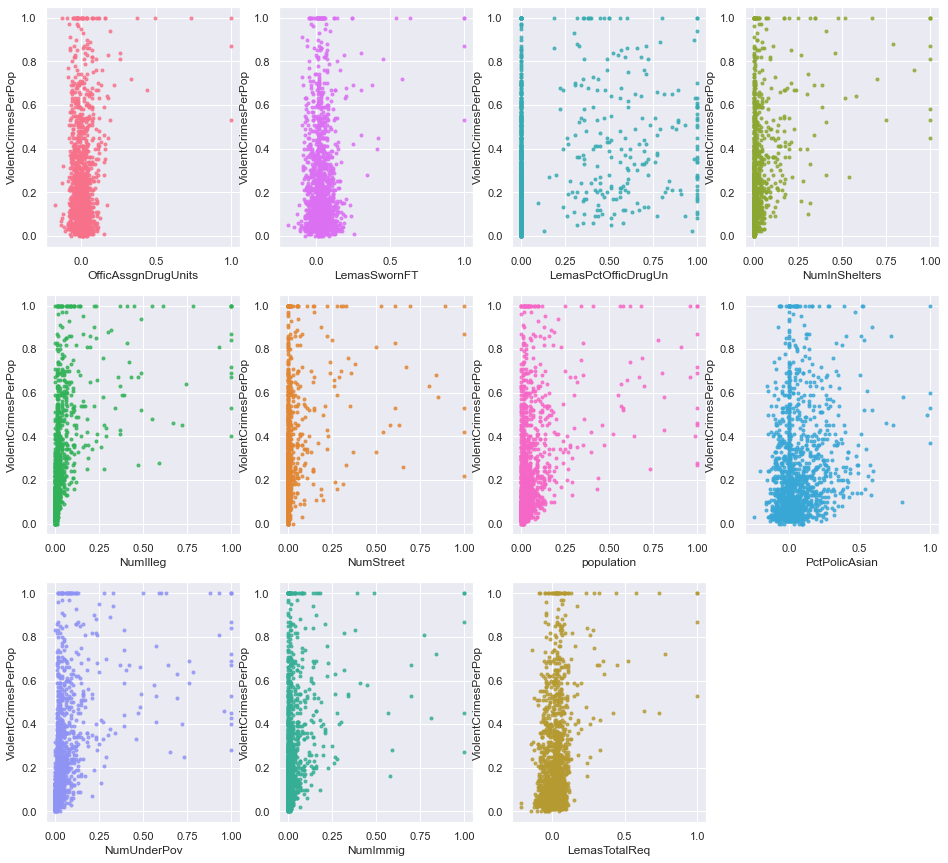

In [9]:
import matplotlib.pyplot as plt

# create a dataframe for visualization
stats_df = df_train[high_cv]
y_train = df_train['ViolentCrimesPerPop']
stats_df = stats_df.join(y_train)

# create scatterplots of each feature against y
color = sns.color_palette('husl', 11)
fig, axes = plt.subplots(3, 4)
fig.set_size_inches(16,15)
for i,t in enumerate(high_cv):
    sns.regplot(data=stats_df, x=t, y='ViolentCrimesPerPop', fit_reg=False, ax = axes[i % 3, i % 4],
                 marker = '.', scatter_kws={'color':color[i]})
fig.delaxes(axes[2][3])

<AxesSubplot:xlabel='value', ylabel='variable'>

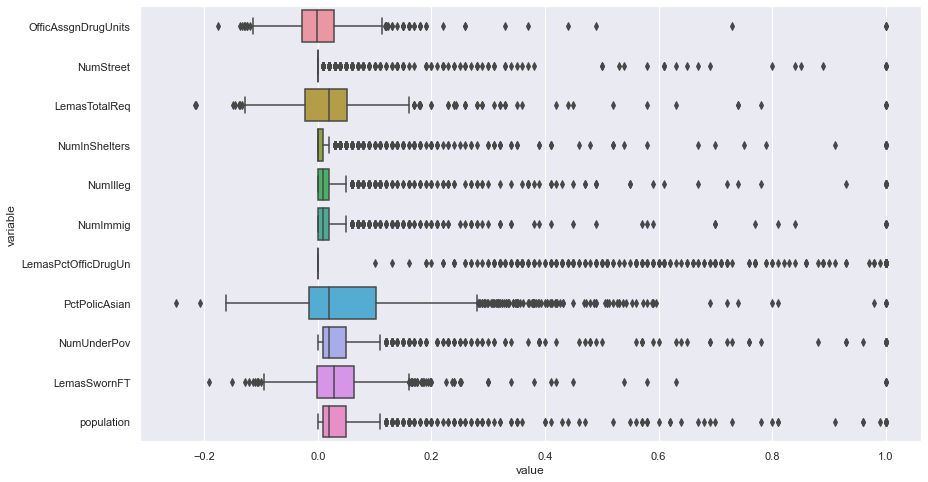

In [10]:
# create boxplot for each feature
f, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(y='variable', x='value', data=stats_df.melt(value_vars=high_cv),orient="h")

In [11]:
print('cannot draw any conclusions about significance of these features as there is no strong correlation')

cannot draw any conclusions about significance of these features as there is no strong correlation


(f)

In [13]:
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import r2_score

# get train/test X, y
X_train = df_train.drop(['ViolentCrimesPerPop'], axis = 1)
X_test = df_test.drop(['ViolentCrimesPerPop'], axis = 1)
y_train = df_train['ViolentCrimesPerPop']
y_test = df_test['ViolentCrimesPerPop']

# fit linear regression model (for some reason it won't work on the first run)
# LinAlgError: SVD did not converge
m_lr = sm.OLS(y_train, sm.add_constant(X_train)).fit()
y_pred = m_lr.predict(sm.add_constant(X_test))

r2_score(y_test,y_pred) # this number is obviously not right

-7346.13925343046

In [14]:
m_lr.summary() # x98 and x104 has super large std err, lemme see what's up

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.785
Model:                             OLS   Adj. R-squared:                  0.766
Method:                  Least Squares   F-statistic:                     41.08
Date:                 Fri, 23 Oct 2020   Prob (F-statistic):               0.00
Time:                         20:48:23   Log-Likelihood:                 1176.5
No. Observations:                 1495   AIC:                            -2107.
Df Residuals:                     1372   BIC:                            -1454.
Df Model:                          122                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.2227      1.079      1.133      0.257      -0.894       3.339
population               -0.6234      0.528     -1.181      0.238      -1.659       0.413
householdsize             0.0628      0.121      0.518      0.605      -0.175       0.301
racepctblack              0.1862      0.082      2.275      0.023       0.026       0.347
racePctWhite              0.0222      0.109      0.203      0.839      -0.192       0.237
racePctAsian             -0.1154      0.052     -2.221      0.027      -0.217      -0.013
racePctHisp              -0.3366      0.103     -3.257      0.001      -0.539      -0.134
agePct12t21               0.1356      0.143      0.948      0.343      -0.145       0.416
agePct12t29              -0.6336      0.197     -3.219      0.001      -1.020      -0.247
agePct16t24               0.0296      0.272      0.109      0.913      -0.503       0.563
agePct65up                0.4160      0.140      2.974      0.003       0.142       0.690
numbUrban                 0.4758      0.520      0.915      0.361      -0.545       1.496
pctUrban                  0.1553      0.069      2.268      0.024       0.021       0.290
medIncome                -0.2830      0.207     -1.368      0.171      -0.689       0.123
pctWWage                  0.1847      0.168      1.099      0.272      -0.145       0.514
pctWFarmSelf             -0.0781      0.034     -2.319      0.021      -0.144      -0.012
pctWInvInc               -0.3398      0.078     -4.365      0.000      -0.492      -0.187
pctWSocSec                0.0227      0.143      0.158      0.874      -0.258       0.304
pctWPubAsst              -0.0518      0.068     -0.760      0.447      -0.186       0.082
pctWRetire               -0.2951      0.059     -4.998      0.000      -0.411      -0.179
medFamInc                 0.1492      0.189      0.788      0.431      -0.222       0.521
perCapInc                 0.1157      0.198      0.585      0.559      -0.273       0.504
whitePerCap              -0.0658      0.164     -0.400      0.689      -0.388       0.257
blackPerCap              -0.1613      0.068     -2.381      0.017      -0.294      -0.028
indianPerCap              0.1102      0.034      3.245      0.001       0.044       0.177
AsianPerCap              -0.0007      0.024     -0.030      0.976      -0.048       0.047
OtherPerCap               0.0376      0.044      0.848      0.397      -0.049       0.125
HispPerCap                0.1862      0.034      5.461      0.000       0.119       0.253
NumUnderPov              -0.2679      0.174     -1.539      0.124      -0.609       0.074
PctPopUnderPov           -0.2043      0.094     -2.166      0.030      -0.389      -0.019
PctLess9thGrade           0.1320      0.075      1.752      0.080      -0.016       0.280
PctNotHSGrad

In [15]:
print(X_train.columns[97], ',',X_train.columns[103])

LemasSwFTPerPop , PolicPerPop


In [16]:
X_train['LemasSwFTPerPop'].corr(X_train['PolicPerPop']) # they are super correlated! drop one of them

0.9999999998858173

In [17]:
# drop feature 'LemasSwFTPerPop' and fit a new model
X_train_new = X_train.drop(['LemasSwFTPerPop'], axis = 1)
X_test_new = X_test.drop(['LemasSwFTPerPop'], axis = 1)
m_lr = sm.OLS(y_train, sm.add_constant(X_train_new)).fit()
y_pred = m_lr.predict(sm.add_constant(X_test_new))

print('test error of linear regression is', r2_score(y_test,y_pred)) # 0.65 isn't great but it's way better than -7346

test error of linear regression is 0.6497829837608085


(g)

In [18]:
from sklearn.linear_model import RidgeCV

# fit ridge regression with built in cv
m_ridge = RidgeCV(alphas = [0.01, 0.1, 1.0, 10.0, 100.0], cv = 5).fit(X_train, y_train)
print('test error of ridge regression is', m_ridge.score(X_test, y_test),'with alpha =', m_ridge.alpha_)

test error of ridge regression is 0.6664853172122485 with alpha = 1.0


(h)

In [19]:
from sklearn.linear_model import LassoCV

# fit lasso regression with built in cv
m_lasso = LassoCV(max_iter = 10000, cv = 5).fit(X_train, y_train)
print('test error of lasso regression is', m_lasso.score(X_test, y_test),'with alpha =', m_lasso.alpha_,'\n')

# get features selected by the model
lasso_var = []
for i in range(len(m_lasso.coef_)):
    if m_lasso.coef_[i] != 0:
        lasso_var.append(X_train.columns[i])
print('features selected by the model:',lasso_var)

test error of lasso regression is 0.6657211030712343 with alpha = 6.646371885446194e-05 

features selected by the model: ['householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'agePct12t21', 'agePct12t29', 'agePct65up', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PctKids2Par', 'PctYoungKids2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'PctIlleg', 'NumImmig', 'PctImmigRecent', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseOccup', 'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctH

In [20]:
from sklearn.preprocessing import StandardScaler

# standardize features
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

# fit new a model with standardized features
m_lasso_std = LassoCV(max_iter = 10000, cv = 5).fit(X_train_std, y_train)
print('test error of lasso regression is', m_lasso_std.score(X_test_std, y_test),'with alpha =', m_lasso_std.alpha_)

test error of lasso regression is 0.6449528361870092 with alpha = 0.0004366643699884344


In [21]:
print('the test error with standardized features is slightly lower than with un-standardized features, but not significant. the original dataset was already normalized, although the process is different from standarization, the result could be similar.')

the test error with standardized features is slightly lower than with un-standardized features, but not significant. the original dataset was already normalized, although the process is different from standarization, the result could be similar.


(i)

In [22]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale 
from sklearn import model_selection

# performing pca on train data
pca = PCA()
X_train_reduced = pca.fit_transform(scale(X_train))

# find best model and report train error and M
n = len(X_train_reduced)
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=0)

r2 = []
r2_index=[]
for i in np.arange(1, 123):
    score = model_selection.cross_val_score(LinearRegression(), X_train_reduced[:,:i], y_train.ravel(),
                                            cv = kf_10, scoring = 'r2').mean()
    r2.append(score)
    r2_index.append(i)

print('the best model has training error of',np.max(r2),'with M =',r2_index[r2.index(np.max(r2))])

the best model has training error of 0.7136071525687863 with M = 95


In [23]:
# fit model with 95 components and report test error
X_test_reduced = pca.fit_transform(scale(X_test))[:, :95]
y_pred = LinearRegression().fit(X_train_reduced[:, :95], y_train).predict(X_test_reduced)

print('test error of PCR is', r2_score(y_test,y_pred))

test error of PCR is 0.3185216101229694


(j)

In [24]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

m_xgb = xgb.XGBRegressor(n_estimators = 100, max_depth = 5)
params = {'reg_alpha':[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}

m_gs = GridSearchCV(estimator = m_xgb, param_grid = params, cv = 10)
m_gs.fit(X_train, y_train)

print('test error of ridge regression is', m_gs.score(X_test, y_test),'with alpha =', m_gs.best_params_)

test error of ridge regression is 0.6792731489856902 with alpha = {'reg_alpha': 1.0}
